<a href="https://colab.research.google.com/github/ddg93/TF_flexfibreAABB/blob/main/RegressDISK_multiview.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Let's build, train and test a Convolutional Neural Network to estimate the pose of a ring suspended in a viscous shear flow:**
## we will work with couples of perpendicular videos recorded by a 2-camera epipolar geometry.

In [ ]:
###import useful modules
import tensorflow as tf
from tensorflow import keras
import numpy as np
import zipfile
import os
import matplotlib.pyplot as plt
from matplotlib import image
import cv2
import re
from sklearn.model_selection import train_test_split
from PIL import Image
import matplotlib.lines as mlines
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, concatenate, Lambda, GaussianNoise
from tensorflow.keras.models import Model
from scipy.ndimage import gaussian_filter1d

# **The CNN will be trained on a synthetic data set:** 
## we generated it using Blender, considering a ring with $r_{in}=0.5$ and $r_{out}=2.5$. 
## Images will be automatically downloaded from an archive, their title being the corresponding label.

In [ ]:
###Check the version of TensorFlow you are using
print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))

2.11.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
###Download the data set from Google Drive
!gdown 1cWHPcDmiUhnr7OY5HdmFH2zDrera90D9 -O data.zip

###Extract the data set
with zipfile.ZipFile('data.zip', 'r') as zip_ref:
    zip_ref.extractall('')

Downloading...
From: https://drive.google.com/uc?id=1cWHPcDmiUhnr7OY5HdmFH2zDrera90D9
To: /content/data.zip
100% 3.51M/3.51M [00:00<00:00, 177MB/s]


In [ ]:
###Set the path of the data set and list all files within
folder = 'R10_25/'
sidefiles = next(os.walk(folder+'side_view/'),(None,None,[]))[2]
topfiles = next(os.walk(folder+'top_view/'),(None,None,[]))[2]
###Look for the .jpg image files and the .txt label files 
sideimages = [x for x in sidefiles if x[-4:] == '.jpg']
topimages = [x for x in topfiles if x[-4:] == '.jpg']
###sort
sideimages.sort()
topimages.sort()
###Read the angles from the side image filenames
n1s = []
n2s = []
n3s = []
for img in (sideimages):
  res = re.findall(r"[-+]?(?:\d*\.*\d+)", img)
  n1s.append(float(res[-5])) ###polar angle, the sign matters
  n2s.append((float(res[-3]))) ###azimuth angle, the sign does not matter
  n3s.append((float(res[-1]))) ###azimuth angle, the sign does not matter
###Read the angles from the top image filenames
n1t = []
n2t = []
n3t = []
for img in (topimages):
  res = re.findall(r"[-+]?(?:\d*\.*\d+)", img)
  n1t.append(float(res[-5])) ###polar angle, the sign matters
  n2t.append((float(res[-3]))) ###azimuth angle, the sign does not matter
  n3t.append((float(res[-1]))) ###azimuth angle, the sign does not matter
###prepare the labels
slbs = [[x,y,z] for x,y,z in zip(n1s,n2s,n3s)]
tlbs = [[x,y,z] for x,y,z in zip(n1t,n2t,n3t)]
###load the side images
sims = []
for imag in sideimages:
  tmp = Image.open(folder+'side_view/'+imag)
  img = np.array(tmp)
  sims.append(img)
###load the top images
tims = []
for imag in topimages:
  tmp = Image.open(folder+'top_view/'+imag)
  img = np.array(tmp)
  tims.append(img)
###check that the images were loaded in the same order
for j in range(len(slbs)):
  if(np.linalg.norm(np.array(slbs[j])-np.array(tlbs[j])) != 0):
    print('ERROR in sorting')

In [ ]:
###prepare the images
tims = np.array(tims) / 255.0 #scale the colors by 255 so they fall in the range 0,1
sims = np.array(sims) / 255.0 #scale the colors by 255 so they fall in the range 0,1
###build a unique numpy array
ims = []
for j in range(len(sims)):
  ims.append(np.array([sims[j],tims[j]]))###the model receives first the side frame and then the above frame
ims = np.array(ims)
###prepare the labels
lbs = np.array(tlbs)  #scale the vector components
lbs[:,0] = (lbs[:,0] + 1.0)/2.0 ### n1 is in the range -1;+1 so we add 1 to make it positive and divide by 2 to normalize it
###randomly split between training set and testing set
X_train, X_test, Y_train, Y_test = train_test_split(ims, lbs, test_size=0.2, random_state=0)

# **Let's have a look at the data set:** 
## images are displayed as a pair, the side view and the top view of the epipolar geometry on the left and right side respectively.

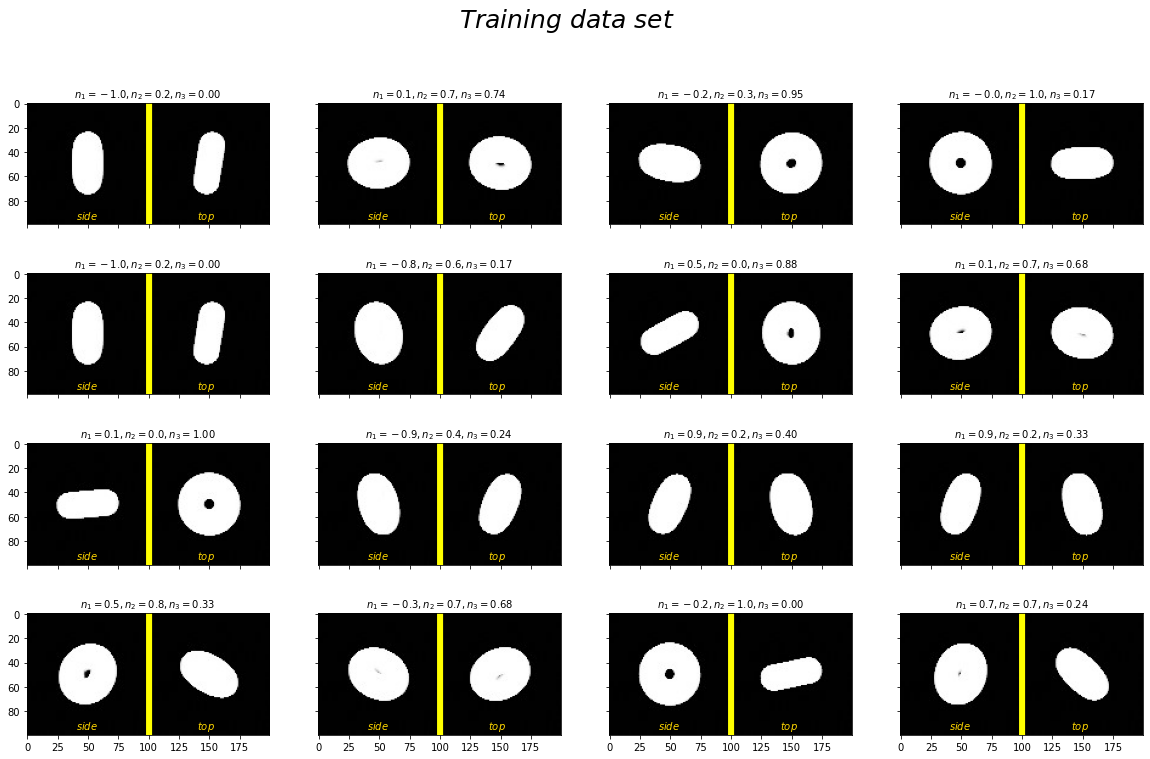

In [ ]:
###Visualize the data set: look at 16 random images
fig,axs = plt.subplots(4,4,sharex=True,sharey=True,figsize=(20,12))  ###create the array of images
inds = np.random.randint(0,len(X_train),axs.shape[0]*axs.shape[1]) ###select 16 random indexes
for j in range(axs.shape[0]):
  for i in range(axs.shape[1]):
    imgS = (X_train[inds[i+axs.shape[1]*j],0,:]*255).astype(np.uint8)   ###load the image
    imgT = (X_train[inds[i+axs.shape[1]*j],1,:]*255).astype(np.uint8)   ###load the image    
    titl = Y_train[inds[i+axs.shape[1]*j]]
    axs[j][i].title.set_text(rf'$ n_1={(titl[0]*2.0)-1.0:.1f}, n_2={(titl[1]):.1f}, n_3={titl[2]:.2f} $' )
    axs[j][i].title.set_size(10)
    imageD = cv2.line(cv2.hconcat([imgS,imgT]), (100, 0), (100, 100), (255, 255, 0), thickness=3)
    axs[j][i].imshow(imageD) ###plot the image
    axs[j][i].text(40,95,r'$side$',fontsize=10,color='gold')
    axs[j][i].text(140,95,r'$top$',fontsize=10,color='gold')
fig.suptitle(r'$Training  \ data \ set$', fontsize=25);

# **Time to build the model,** 
## but first we define a custom loss funtion that calculates the Euclidean norm of the difference between the predicted and true particle orientation vectors

In [ ]:
def custom_loss(y_true,y_pred):
    ###norm 2 of the difference between predicted and true particle orientation vectors 
    norm = tf.norm((y_true-y_pred),axis=-1)
    loss = tf.math.reduce_sum(norm)
    return loss

In [ ]:
###Define the sizes of the Conv2D layers
size1 = 8
size2 = 8
size3 = 16
###Gaussian noise layer std
stddev = 0.1
# Define the input shape for two images
input_shape = (100, 100, 3)
# Define the first input for image 1
input1 = Input(shape=input_shape)
#Gaussian noise layer
#gaus1 = GaussianNoise(stddev)(input1)
# Convolutional layers for image 1
conv1_1 = Conv2D(size1, kernel_size=(3, 3), activation='relu', padding='same')(input1)
maxpool1_1 = MaxPooling2D(pool_size=(2, 2))(conv1_1)
#conv1_2 = Conv2D(size2, kernel_size=(3, 3), activation='relu', padding='same')(maxpool1_1)
#maxpool1_2 = MaxPooling2D(pool_size=(2, 2))(conv1_2)
#conv1_3 = Conv2D(size3, kernel_size=(3, 3), activation='relu', padding='same')(maxpool1_2)
#maxpool1_3 = MaxPooling2D(pool_size=(2, 2))(conv1_3)
# Define the second input for image 2
input2 = Input(shape=input_shape)
#Gaussian noise layer
#gaus2 = GaussianNoise(stddev)(input2)
# Convolutional layers for image 2
conv2_1 = Conv2D(size1, kernel_size=(3, 3), activation='relu', padding='same')(input2)
maxpool2_1 = MaxPooling2D(pool_size=(2, 2))(conv2_1)
#conv2_2 = Conv2D(size2, kernel_size=(3, 3), activation='relu', padding='same')(maxpool2_1)
#maxpool2_2 = MaxPooling2D(pool_size=(2, 2))(conv2_2)
#conv2_3 = Conv2D(size3, kernel_size=(3, 3), activation='relu', padding='same')(maxpool2_2)
#maxpool2_3 = MaxPooling2D(pool_size=(2, 2))(conv2_3)
# Concatenate the output of the convolutional layers for both images
concat = concatenate([maxpool1_1, maxpool2_1])
# Flatten the output of the convolutional layers
flatten = Flatten()(concat)
dense1 = Dense(64, activation='relu')(flatten)
#dense2 = Dense(32, activation='relu')(dense1)
output = Dense(3, activation='linear')(dense1)
###output = Lambda(lambda x: tf.math.l2_normalize(x,axis=-1,epsilon=1e-12))(final_dense)
# Define the model with two inputs and one output
model = Model(inputs=[input1, input2], outputs=output)
#model.compile(loss='mean_squared_error', optimizer="adam", metrics=["accuracy"])
model.compile(loss=custom_loss, optimizer="adam", metrics=["accuracy"])
###Report of the model
model.summary()

Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_43 (InputLayer)          [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_44 (InputLayer)          [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_42 (Conv2D)             (None, 100, 100, 8)  224         ['input_43[0][0]']               
                                                                                           

# **Let's train and test the model:**
## we evaluate its accuracy by calculating the absolute error on the three components of the particle orientation vector indipendently.

In [ ]:
###Fit the model on the training data set
histo = model.fit([X_train[:,0,:],X_train[:,1,:]], Y_train, epochs=10, batch_size=16,  verbose=1)

Epoch 1/10
39/39 [==============================] - 2s 6ms/step - loss: 10.3053 - accuracy: 0.7800
Epoch 2/10
39/39 [==============================] - 0s 6ms/step - loss: 2.1637 - accuracy: 0.9146
Epoch 3/10
39/39 [==============================] - 0s 6ms/step - loss: 1.8366 - accuracy: 0.9310
Epoch 4/10
39/39 [==============================] - 0s 6ms/step - loss: 1.5248 - accuracy: 0.9343
Epoch 5/10
39/39 [==============================] - 0s 6ms/step - loss: 1.0880 - accuracy: 0.9524
Epoch 6/10
39/39 [==============================] - 0s 6ms/step - loss: 0.9123 - accuracy: 0.9622
Epoch 7/10
39/39 [==============================] - 0s 6ms/step - loss: 0.9653 - accuracy: 0.9754
Epoch 8/10
39/39 [==============================] - 0s 6ms/step - loss: 0.8649 - accuracy: 0.9721
Epoch 9/10
39/39 [==============================] - 0s 6ms/step - loss: 0.7385 - accuracy: 0.9787
Epoch 10/10
39/39 [==============================] - 0s 6ms/step - loss: 0.6977 - accuracy: 0.9704


In [ ]:
###Evaluate the test set
Y_pred = model.predict([X_test[:,0,:],X_test[:,1,:]])

5/5 [==============================] - 0s 6ms/step


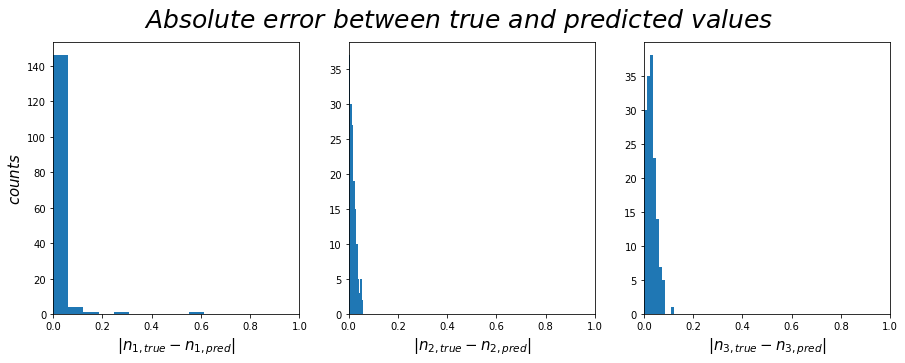

In [ ]:
fig,axs = plt.subplots(1,3,figsize=(15,5))
axs[0].hist(abs(Y_pred[:,0]-Y_test[:,0]))
axs[1].hist(abs(Y_pred[:,1]-Y_test[:,1]))
axs[2].hist(abs(Y_pred[:,2]-Y_test[:,2]))

axs[0].set_ylabel(r'$counts$',fontsize=15)

axs[0].set_xlim(0,1)
axs[1].set_xlim(0,1)
axs[2].set_xlim(0,1)

axs[0].set_xlabel(r'$\vert n_{1,true}-n_{1,pred}\vert$',fontsize=15)
axs[1].set_xlabel(r'$\vert n_{2,true}-n_{2,pred}\vert$',fontsize=15)
axs[2].set_xlabel(r'$\vert n_{3,true}-n_{3,pred}\vert$',fontsize=15)

fig.suptitle(r'$Absolute \ error \ between \ true \ and \ predicted \ values$', fontsize=25);

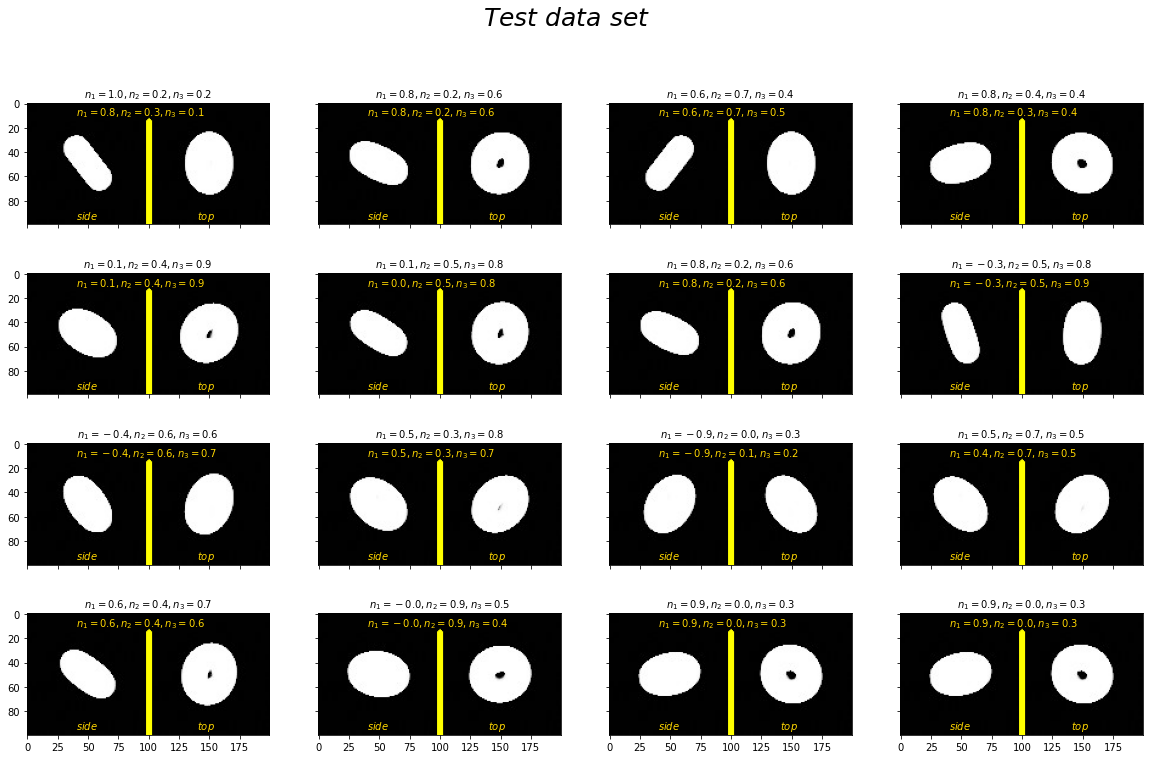

In [ ]:
###Visualize the predictions: look at 16 random images
fig,axs = plt.subplots(4,4,sharex=True,sharey=True,figsize=(20,12))  ###create the array of images
inds = np.random.randint(0,len(X_test),axs.shape[0]*axs.shape[1]) ###select 16 random indexes
for j in range(axs.shape[0]):
  for i in range(axs.shape[1]):
    imgS = (X_train[inds[i+axs.shape[1]*j],0,:]*255).astype(np.uint8)   ###load the image
    imgT = (X_train[inds[i+axs.shape[1]*j],1,:]*255).astype(np.uint8)   ###load the image
    
    
    titl = Y_test[inds[i+axs.shape[1]*j]]
    axs[j][i].title.set_text(rf'$ n_1={(titl[0]*2.0)-1.0:.1f}, n_2={(titl[1]):.1f}, n_3={titl[2]:.1f} $' )
    axs[j][i].title.set_size(10)
    imageD = cv2.line(cv2.hconcat([imgS,imgT]), (100, 15), (100, 100), (255, 255, 0), thickness=3)
    axs[j][i].imshow(imageD) ###plot the image
    axs[j][i].text(40,95,r'$side$',fontsize=10,color='gold')
    axs[j][i].text(140,95,r'$top$',fontsize=10,color='gold')
    titl = Y_pred[inds[i+axs.shape[1]*j]]
    axs[j][i].text(40,10,rf'$ n_1={(titl[0]*2.0)-1.0:.1f}, n_2={(titl[1]):.1f}, n_3={titl[2]:.1f} $',color='gold',fontsize=10)
    
fig.suptitle(r'$Test  \ data \ set$', fontsize=25);


# **Let's test the CNN on two videos of a real experiment with a ring that was 3D printed from the .stl file used to generate the renderings of the data set!**

In [ ]:
###Download the two videos of one experiment:
###TOP:
!gdown 1pjdgnvKMVaJlL5jENC_Gcl6x1HyW_4b6 -O top.avi
#https://drive.google.com/file/d/1pjdgnvKMVaJlL5jENC_Gcl6x1HyW_4b6/view?usp=sharing

###SIDE:
!gdown 1LxJJ-2Msn3lNL0q8AvzdnU4pwaQZ4wVF -O side.avi
#https://drive.google.com/file/d/1LxJJ-2Msn3lNL0q8AvzdnU4pwaQZ4wVF/view?usp=sharing

Downloading...
From: https://drive.google.com/uc?id=1pjdgnvKMVaJlL5jENC_Gcl6x1HyW_4b6
To: /content/top.avi
100% 232k/232k [00:00<00:00, 117MB/s]
Downloading...
From: https://drive.google.com/uc?id=1LxJJ-2Msn3lNL0q8AvzdnU4pwaQZ4wVF
To: /content/side.avi
100% 208k/208k [00:00<00:00, 96.6MB/s]


In [ ]:
###Read the top frames
topframes = []
cap = cv2.VideoCapture('top.avi')
dim = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
for j in range(dim):
  ret,frame = cap.read()
  topframes.append(frame)
cap.release()
topframes = np.array(topframes)
###Read the side frames
sidframes = []
cap = cv2.VideoCapture('side.avi')
dim = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
for j in range(dim):
  ret,frame = cap.read()
  sidframes.append(frame)
cap.release()
sidframes = np.array(sidframes)
print(f'working on {dim} frames!')
###Normalize the image colors to fall in the range 0,1
sidframes = sidframes / 255.0
topframes = topframes / 255.0

working on 183 frames!


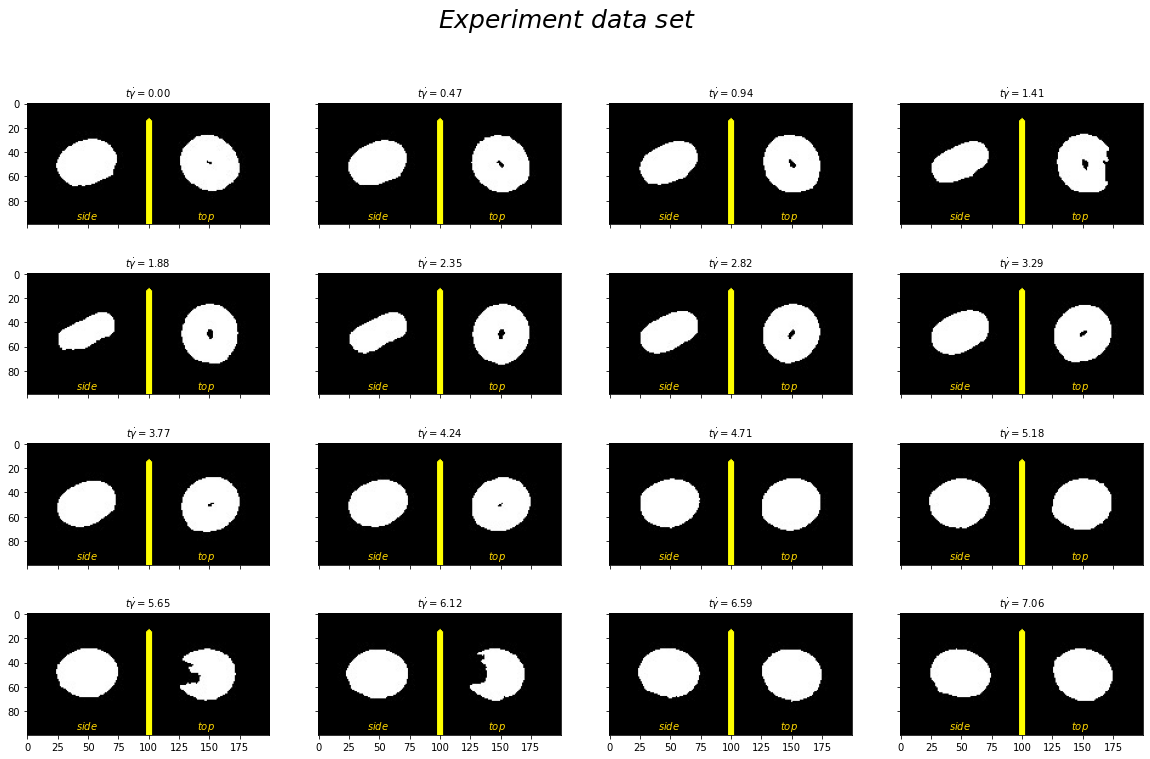

In [ ]:
###Visualize the experiments: look at 16 random images
fig,axs = plt.subplots(4,4,sharex=True,sharey=True,figsize=(20,12))  ###create the array of images
inds = np.linspace(0,len(sidframes),len(sidframes)).astype(int) ###select 16 random indexes
for j in range(axs.shape[0]):
  for i in range(axs.shape[1]):
    imgS = (sidframes[inds[i+axs.shape[1]*j],:]*255.0).astype(np.uint8)   ###load the image
    imgT = (topframes[inds[i+axs.shape[1]*j],:]*255.0).astype(np.uint8)   ###load the image
    ###Concatenate the two images and print: side frame on the left, above frame on the right
    imageD = cv2.line(cv2.hconcat([imgS,imgT]), (100, 15), (100, 100), (255, 255, 0), thickness=3)
    axs[j][i].imshow(imageD) ###plot the image
    axs[j][i].text(40,95,r'$side$',fontsize=10,color='gold')
    axs[j][i].text(140,95,r'$top$',fontsize=10,color='gold')
    #titl = Y_pred[inds[i+axs.shape[1]*j]]
    #axs[j][i].text(40,10,rf'$ n_1={(titl[0]*2.0)-1.0:.1f}, n_2={(titl[1]*2.0)-1.0:.1f}, n_3={titl[2]:.1f} $',color='gold',fontsize=10)
  
    axs[j][i].title.set_text(rf'$ t \dot\gamma = {inds[i+axs.shape[1]*j]/7.5 * 3.53 :.2f} $' )
    axs[j][i].title.set_size(10)

fig.suptitle(r'$Experiment  \ data \ set$', fontsize=25);


In [ ]:
###predict
Y_manip = model.predict([sidframes,topframes[:183,:]])
Y_manip[:,0] = (Y_manip[:,0]*2.0)-1.0
###Post-process the data to restore the sign of n2, smooth the result and initialize the time and shear rate of the experiment
###timeline
time = np.linspace(0,len(sidframes)/7.5,len(sidframes))
###shear rate
gdot = 3.54
###Post-process: normalize so that the vector has Euclidean norm = 1
for j in range(len(Y_manip[:,0])):
  Y_manip[j,:] = Y_manip[j,:] / np.linalg.norm(Y_manip[j,:])
###Smooth
sgm = 2.0
Y_manip[:,0] = gaussian_filter1d(Y_manip[:,0],sgm)
Y_manip[:,1] = gaussian_filter1d(Y_manip[:,1]*np.sign(np.gradient(Y_manip[:,0],time)),sgm)
Y_manip[:,2] = gaussian_filter1d(Y_manip[:,2],sgm)

6/6 [==============================] - 0s 7ms/step


# **Finally we display the result:** 
## the ring exibits a periodic motion known as Jeffery Orbits, typical of axisymmetrical particles suspended in a viscous shear flow!

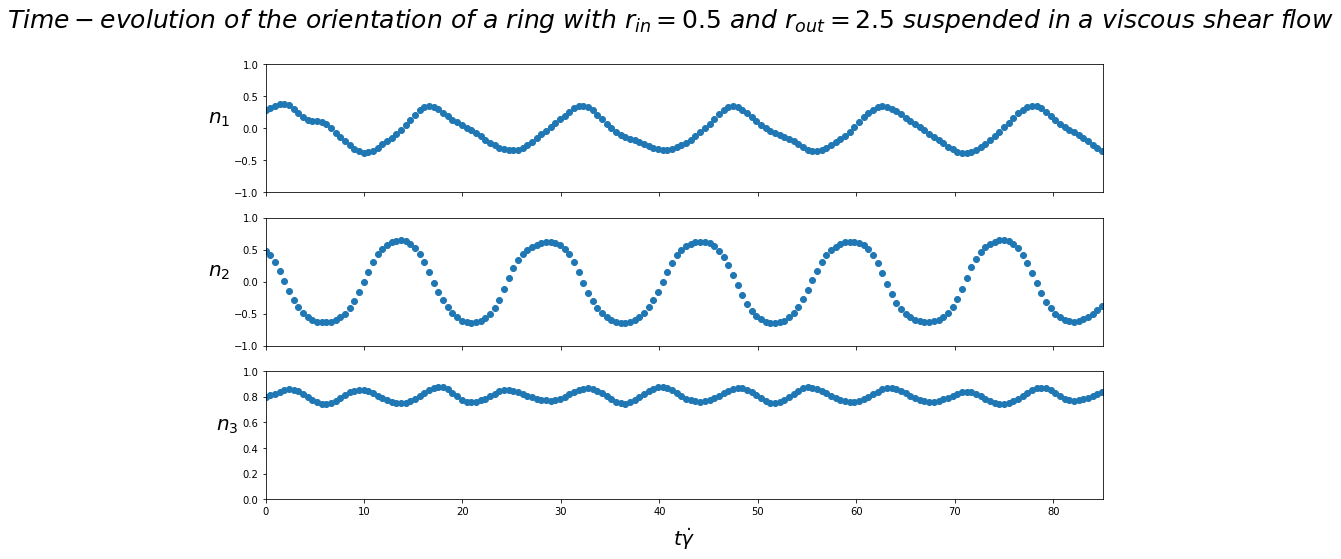

In [ ]:
###Display the reconstruction of the experiment
fig,axs = plt.subplots(3,1,sharex=True,figsize=(15,8))
axs[0].scatter(time*gdot,Y_manip[:,0]) ###component of the particle orientation vector in the flow direction x
axs[1].scatter(time*gdot,Y_manip[:,1]) ###component of the particle orientation vector in the gradient direction y
axs[2].scatter(time*gdot,Y_manip[:,2]) ###component of the particle orientation vector in the vorticity direction z
###Format
axs[0].set_ylim(-1,1)
axs[1].set_ylim(-1,1)
axs[2].set_ylim(0,1)
axs[2].set_xlim(0,85)
###Labels
axs[0].set_ylabel(r'$\mathit{n_1}$',fontsize=20,rotation=0,labelpad=15)
axs[1].set_ylabel(r'$\mathit{n_2}$',fontsize=20,rotation=0,labelpad=15)
axs[2].set_ylabel(r'$\mathit{n_3}$',fontsize=20,rotation=0,labelpad=15)
axs[2].set_xlabel(r'$\mathit{t \dot{\gamma}}$',fontsize=20,labelpad=10)
###Title
fig.suptitle(r'$Time-evolution \ of \ the \ orientation \ of \ a \ ring \ with \ r_{in}=0.5 \ and \ r_{out}=2.5 \ suspended \ in \ a \ viscous \ shear \ flow$', fontsize=25);